## HS-Palmer omics traits analysis：

This notebook explains the process for obtaining and pre-processing omics mean genotype data of HS Rats used for downstream association studies.

In [4]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim, StatsBase
using Random, Distributions
using BenchmarkTools
using Plots

In [3]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/HS-Palmer"

In [4]:
local_path = "../../BulkLMM.jl/src";

In [5]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

### Load omics traits and convert to array:

In [5]:
@time omics_pheno_df = CSV.read("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Rat-PL-RSeq-0818_nomissing.csv", DataFrame);

 13.108736 seconds (8.59 M allocations: 486.350 MiB, 1.34% gc time, 90.16% compilation time)


In [6]:
omics_pheno_df[1:10, 1:10]

Row,id,ENSRNOG00000000001,ENSRNOG00000000007,ENSRNOG00000000008,ENSRNOG00000000009,ENSRNOG00000000010,ENSRNOG00000000012,ENSRNOG00000000017,ENSRNOG00000000021,ENSRNOG00000000024
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,00077E67B5,3.6379,11.9384,1.5656,0.142,8.1366,4.2163,2.9092,7.6822,9.5078
2,00077E76FE,3.7742,11.9253,1.5245,-0.068,8.2848,4.663,2.8339,7.8128,9.5016
3,00077E8336,3.554,12.2001,1.3987,-0.0679,8.1853,4.5741,2.5846,7.705,9.4759
4,00077EA7E6,3.3301,11.9553,1.6367,-0.0218,8.066,4.4902,2.5845,7.6575,9.3513
5,00078A0224,3.5547,12.0272,1.5649,-0.0217,8.3169,4.5341,2.6773,7.8402,9.3225
6,00078A02CB,3.8215,12.0395,1.3515,-0.0679,8.3208,4.5923,2.6765,7.6363,9.4791
7,00078A0A43,3.6407,12.0575,1.4871,-0.0678,8.2847,4.6763,2.7223,7.7997,9.4048
8,00078A18A7,3.6343,12.0777,1.4854,-0.0679,8.0468,4.7543,2.7599,7.8119,9.3522
9,00078A193E,3.6807,12.1188,1.5244,-0.068,8.1551,4.8433,2.7173,7.9472,9.2675


Column names are the names of the omics:

In [7]:
names(omics_pheno_df)[1:6]

6-element Vector{String}:
 "id"
 "ENSRNOG00000000001"
 "ENSRNOG00000000007"
 "ENSRNOG00000000008"
 "ENSRNOG00000000009"
 "ENSRNOG00000000010"

Row names are the ID's of the samples. Obtaining sample id's for the samples of the omics traits...

In [8]:
sample_ids = omics_pheno_df[:, 1];

Get the numeric array of the traits data...

In [12]:
omics_pheno = omics_pheno_df[:, 2:end] |> Matrix{Float64};
omics_pheno[1:6, :]

6×32623 Matrix{Float64}:
 3.6379  11.9384  1.5656   0.142   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.7742  11.9253  1.5245  -0.068      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.554   12.2001  1.3987  -0.0679     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.3301  11.9553  1.6367  -0.0218     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.5547  12.0272  1.5649  -0.0217     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.8215  12.0395  1.3515  -0.0679  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Notice that there are some traits with all 0.0 values. Remove missings or columns of all 0's...

In [10]:
no_value_traits = vec(sum(omics_pheno, dims = 1) .== 0.0);

In [11]:
omics_pheno_processed = omics_pheno[:, map(x -> x .== 0.0, no_value_traits)];

### Load omics genotype data and convert to array:

In [14]:
@time omics_geno_df = CSV.read("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Palmer_true_omics_geno_nomissing.csv", DataFrame);

  2.634146 seconds (7.03 M allocations: 436.083 MiB, 4.59% gc time, 97.02% compilation time)


In [16]:
omics_geno_df

Row,Chr,Locus,cM,Mb,00077E67B5,00077E76FE,00077E8336,00077EA7E6,00078A002C,00078A0041,00078A0058,00078A0085,00078A00AC,00078A00BF,00078A01A6,00078A01C0,00078A01D8,00078A01DB,00078A01FE,00078A02CB,00078A02DF,00078A07A2,00078A09B1,00078A021A,00078A022D,00078A087B,00078A096C,00078A0127,00078A0138,00078A0139,00078A0166,00078A0215,00078A0224,00078A0246,00078A0255,00078A0A43,00078A0AEA,00078A1A2B,00078A1A16,00078A1B05,00078A1F34,00078A16D3,00078A16DF,00078A17F7,00078A18A7,00078A18CF,00078A18F7,00078A19A7,00078A19B5,00078A19C0,00078A19D6,00078A22DF,00078A22EB,00078A179C,00078A181B,00078A186C,00078A192C,00078A193E,00078A194B,00078A261F,00078A1707,00078A1731,00078A1732,00078A1772,00078A1807,00078A1816,00078A1837,00078A1863,00078A1875,00078A1937,00078A1942,00078A1979,00078A2315,00078A2463,00078A2496,00078A2595,00078A2667,000789FF6E,000789FF7D,000789FF94,000789FFD3,000789FFF0,000789FFF8,000789FFF9
,Int64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,chr1:55365,0.055365,0.055365,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
2,1,chr1:666374,0.666374,0.666374,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1,chr1:666382,0.666382,0.666382,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1,chr1:666394,0.666394,0.666394,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
5,1,chr1:669529,0.669529,0.669529,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
6,1,chr1:669562,0.669562,0.669562,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
7,1,chr1:671466,0.671466,0.671466,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0

In [71]:
@time omics_geno = omics_geno_df[:, 5:end] |> Array{Float64, 2} |> x -> permutedims(x) |> x -> x./2.0;

  0.193203 seconds (149.35 k allocations: 336.430 MiB, 25.71% compilation time)


In [72]:
@time omics_marker_names = omics_geno_df.Locus |> Array{String, 1};
omics_marker_names[1:6]

  0.003233 seconds (134.68 k allocations: 5.138 MiB)


6-element Vector{String}:
 "chr1:55365"
 "chr1:666374"
 "chr1:666382"
 "chr1:666394"
 "chr1:669529"
 "chr1:669562"

#### Filter markers by MAF within the range of (0.05, 0.95)

In [73]:
@time maf_omics_geno = vec(mean(omics_geno; dims = 1));

  0.009708 seconds (10 allocations: 1.028 MiB)


In [74]:
to_keep = map(x -> (x < 0.95) & (x > 0.05), maf_omics_geno);

In [75]:
omics_marker_names

134681-element Vector{String}:
 "chr1:55365"
 "chr1:666374"
 "chr1:666382"
 "chr1:666394"
 "chr1:669529"
 "chr1:669562"
 "chr1:671466"
 "chr1:759319"
 "chr1:1134030"
 "chr1:1139210"
 "chr1:1143318"
 "chr1:1151014"
 "chr1:1151294"
 ⋮
 "chr20:55641278"
 "chr20:55644746"
 "chr20:55659520"
 "chr20:55716379"
 "chr20:55744179"
 "chr20:55773139"
 "chr20:55818290"
 "chr20:55944342"
 "chr20:55963803"
 "chr20:55991426"
 "chr20:55999627"
 "chr20:56115597"

In [76]:
omics_geno

80×134681 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985  …  1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.988      1.0  1.0  0.999   0.0065  1.0
 0.5  1.0  1.0  1.0  1.0  1.0  1.0  0.4955     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  0.5  0.5  0.5  1.0  1.0  0.9895     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0035     0.5  0.5  0.498   0.0455  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.9895  …  1.0  1.0  0.999   0.0065  1.0
 0.5  0.5  1.0  1.0  1.0  0.5  1.0  0.4955     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.004      1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.9895     1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985  …  1.0  1.0  0.999   0.0065  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.4985     1.0  0.5  0.9975  0.007   1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0035     1.

In [80]:
omics_geno_processed = omics_geno[:, to_keep];
omics_marker_names_processed = omics_marker_names[to_keep];

In [81]:
(n, m) = size(omics_pheno_processed);
p = size(omics_geno_processed, 2);

In [82]:
n, m, p

(80, 18416, 117618)

### Load BulkLMM functions:

In [85]:
local_path = "/home/zyu20/git/BulkLMM.jl/src";

In [86]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

In [87]:
@time omics_kinship = calcKinship(omics_geno_processed);

  8.689408 seconds (31.60 k allocations: 13.847 GiB, 1.52% gc time)


In [88]:
BLAS.get_num_threads()

8

In [89]:
BLAS.set_num_threads(8)

## BulkLMM:

In [129]:
grid_fine = collect(0.00:0.01:0.99);

In [91]:
grid_loose = collect(0.00:0.05:0.95);

In [132]:
t_null_grid20 = @elapsed bulkscan_null_grid_results = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_loose; reml = false);

In [133]:
t_null_grid100 = @elapsed bulkscan_null_grid_results = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_fine; reml = false);

In [137]:
# @elapsed bulkscan_alt_grid_results = bulkscan_alt_grid(omics_pheno_nozeros, omics_geno_nomissing_filtered, omics_kinship, grid_loose);

## GEMMA:

In [105]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

"/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [139]:
rand_samples = sample(1:m, 1000);

In [140]:
pheno_filename = "data/GEMMA_data/hs_omics_pheno.txt";
geno_filename = "data/GEMMA_data/hs_omics_geno.txt";
kinship_filename = "data/GEMMA_data/hs_omics_kinship.txt";
output_filename = "results_univariate_LMM";

In [ ]:
t_gemma = @elapsed gemma_samples_results = run_gemma(omics_pheno_processed[:, rand_samples], omics_geno_processed, omics_kinship,
                                        ["A", "B"], omics_marker_names_processed,
                                        pheno_filename, geno_filename, kinship_filename, 
                                        output_filename, 
                                        gemma);

GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 80
## number of analyzed individuals = 80
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =   117618
## number of analyzed SNPs         =   117618
Start Eigen-Decomposition...
pve estimate =nan
se(pve) =nan
================================================== 100%


**** INFO: Done.


GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 
## number of total individuals = 80
## number of analyzed individuals = 80
## number of covariates = 1
## number of phenotypes = 1
## number of total SNPs/var        =   117618
## number of analyzed SNPs         =   117618
Start Eigen-Decomposition...
pve estimate =3.5548e-06
se(pve) =1.02131
================================================== 100%


**** INFO: Done.


GEMMA 0.98.5 (2021-08-25) by Xiang Zhou, Pjotr Prins and team (C) 2012-2021
Reading Files ... 


In [ ]:
t_gemma

In [ ]:
runtime_results_file = open("output/runtimes_omics.txt", "w")
write(runtime_results_file, "BulkLMM Alg:null_grid20 runtime = $t_null_grid20 seconds \n");
write(runtime_results_file, "BulkLMM Alg:null_grid100 runtime = $t_null_grid100 seconds \n");
write(runtime_results_file, "Gemma runtime = $t seconds");
close(runtime_results_file)

In [ ]:
writedlm("output/gemma_L_omics.txt", gemma_samples_results, '\t');

In [ ]:
writedlm("output/samples.txt", rand_samples, '\t');

In [ ]:
# @elapsed bulkscan_alt_grid_results = bulkscan_alt_grid(omics_pheno_nozeros, omics_geno_nomissing_filtered, omics_kinship, grid_loose);

In [113]:
rand_samples

5-element Vector{Int64}:
  1908
 14010
 14788
  7511
  3874

In [110]:
# marker_names_fake = "marker: " .* string.(collect(1:p));
#= 
@time gemma_samples_results = run_gemma(omics_pheno_processed[:, rand_samples], omics_geno_processed, omics_kinship,
                                        ["A", "B"], marker_names_fake,
                                        pheno_filename, geno_filename, kinship_filename, 
                                        output_filename, 
                                        gemma);
=# 

In [114]:
hcat(bulkscan_null_grid_results.L[:, 1908], gemma_samples_results[:, 1])

117618×2 Matrix{Float64}:
 0.00421199  0.000909117
 0.616251    0.481451
 0.237365    0.349409
 0.359675    0.598705
 0.18627     0.259545
 0.157039    0.3082
 0.0855972   0.189591
 0.0340158   0.131771
 0.0237165   0.0481716
 0.267427    0.362764
 0.133714    0.280036
 0.216543    0.50032
 0.931258    0.730881
 ⋮           
 0.315665    0.310618
 0.259154    0.250276
 0.257433    0.24849
 0.258611    0.249771
 0.257425    0.248942
 0.259154    0.250276
 0.230911    0.235171
 0.202456    0.25768
 0.437362    0.581754
 0.274627    0.393988
 0.433282    0.589516
 0.425777    0.58111

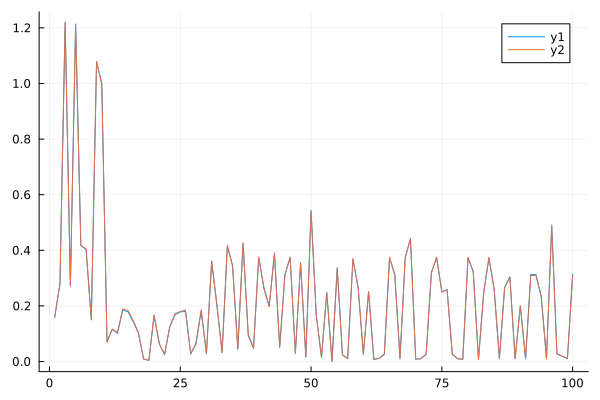

In [ ]:
plot(bulkscan_null_grid_results.L[:, 49][1:100])
plot!(gemma_lods[1:100])

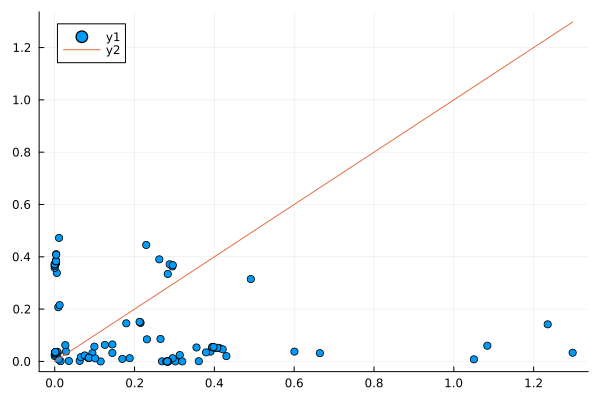

In [ ]:
scatter(test_trait1.lod[1:100], gemma_lods[1:100])
plot!(x -> x)

In [ ]:
function meanAbsDiff(x, y)
    
    return mean(abs.(x .- y))
    
end

meanAbsDiff (generic function with 1 method)

In [114]:
function removeInfValues!(x, y)
    
    toRemove = findall(isinf.(x));
    
    for inf_val in toRemove
        
        x[inf_val[1], inf_val[2]] = 0.0;
        y[inf_val[1], inf_val[2]] = 0.0;
        
    end
    
end

removeInfValues! (generic function with 2 methods)

In [115]:
removeInfValues!(gemma_lods, test_trait1.lod)

In [116]:
meanAbsDiff(gemma_lods, test_trait1.lod)

0.2825154293449414

- Identical genotype probabilities at some markers for all samples;